In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [2]:
data0 = pd.read_csv("/Users/ammar/Documents/diabetes.csv")
data0[0:5].T

,0,1,2,3,4
patient_number,1,2,3,4,5
cholesterol,193,146,217,226,164
glucose,77,79,75,97,91
hdl_chol,49,41,54,70,67
chol_hdl_ratio,"3,9","3,6",4,"3,2","2,4"
age,19,19,20,20,20
gender,female,female,female,female,female
height,61,60,67,64,70
weight,119,135,187,114,141
bmi,"22,5","26,4","29,3","19,6","20,2"


In [3]:
data0.columns

Index(['patient_number', 'cholesterol', 'glucose', 'hdl_chol',
       'chol_hdl_ratio', 'age', 'gender', 'height', 'weight', 'bmi',
       'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist_hip_ratio',
       'diabetes'],
      dtype='object')

In [4]:
n=len(data0)
print(n)

390


In [5]:
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

In [6]:
bmi=[]
for item in data0['bmi']:
    bmi+=[float(item.replace(',','.'))]
data0['bmi']=bmi

In [7]:
waist_hip_ratio=[]
for item in data0['waist_hip_ratio']:
    waist_hip_ratio+=[float(item.replace(',','.'))]
data0['waist_hip_ratio']=waist_hip_ratio

In [8]:
chol_hdl_ratio=[]
for item in data0['chol_hdl_ratio']:
    chol_hdl_ratio+=[float(item.replace(',','.'))]
data0['chol_hdl_ratio']=chol_hdl_ratio

In [9]:
data0['gender']=data0['gender'].map({'female':0,'male':1}).astype(int)
data0['diabetes']=data0['diabetes'].map({'No diabetes':0,'Diabetes':1}).astype(int)

In [10]:
data0[0:5].T

,0,1,2,3,4
patient_number,1.00,2.00,3.00,4.00,5.00
cholesterol,193.00,146.00,217.00,226.00,164.00
glucose,77.00,79.00,75.00,97.00,91.00
hdl_chol,49.00,41.00,54.00,70.00,67.00
chol_hdl_ratio,3.90,3.60,4.00,3.20,2.40
age,19.00,19.00,20.00,20.00,20.00
gender,0.00,0.00,0.00,0.00,0.00
height,61.00,60.00,67.00,64.00,70.00
weight,119.00,135.00,187.00,114.00,141.00
bmi,22.50,26.40,29.30,19.60,20.20


# Target setting

In [11]:
datay0=data0['diabetes']
datax0=data0.drop(['diabetes','patient_number'],axis=1)
datax0[0:5].T

,0,1,2,3,4
cholesterol,193.00,146.00,217.00,226.00,164.00
glucose,77.00,79.00,75.00,97.00,91.00
hdl_chol,49.00,41.00,54.00,70.00,67.00
chol_hdl_ratio,3.90,3.60,4.00,3.20,2.40
age,19.00,19.00,20.00,20.00,20.00
gender,0.00,0.00,0.00,0.00,0.00
height,61.00,60.00,67.00,64.00,70.00
weight,119.00,135.00,187.00,114.00,141.00
bmi,22.50,26.40,29.30,19.60,20.20
systolic_bp,118.00,108.00,110.00,122.00,122.00


In [12]:
datax0.shape

(390, 14)

In [13]:
datax2=np.array(datax0)
datay2=np.array(datay0)

In [14]:
m=len(datax2)
M=[]
for i in range(m):
    M+=[i]
random.shuffle(M)

# Train and test setting

In [15]:
train=datax2[M[0:(n//10)*8]]
test=datax2[M[(n//10)*8:]]
trainy=datay2[M[0:(n//10)*8]]
testy=datay2[M[(n//10)*8:]]

In [16]:
df_columns = list(datax0.columns)
print(df_columns)

['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist_hip_ratio']


In [17]:
train_df=pd.DataFrame(train)
test_df=pd.DataFrame(test)

In [18]:
train_df.columns=df_columns
test_df.columns=df_columns

In [19]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [20]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [21]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [22]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 160.28it/s]


createcreate_numeric_feature  0.004[s]


100%|██████████| 1/1 [00:00<00:00, 548.20it/s]

createcreate_numeric_feature  0.001[s]


# Model

In [23]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [24]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [25]:
y = trainy

In [26]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

/var/folders/6g/07jc7dh93xx_6f0gtc8z08zr0000gn/T/ipykernel_1890/3566126545.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 0.221781
fit fold=0  0.081[s]
Fold 0 RMSLE: 0.2218

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.204907
fit fold=1  0.055[s]
Fold 1 RMSLE: 0.2049

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.236401
fit fold=2  0.036[s]
Fold 2 RMSLE: 0.2364

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.289934
fit fold=3  0.043[s]
Fold 3 RMSLE: 0.2899

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 0.21006
fit fold=4  0.068[s]
Fold 4 RMSLE: 0.2101

--------------------------------------------------
FINISHED | Whole RMSLE: 0.2345


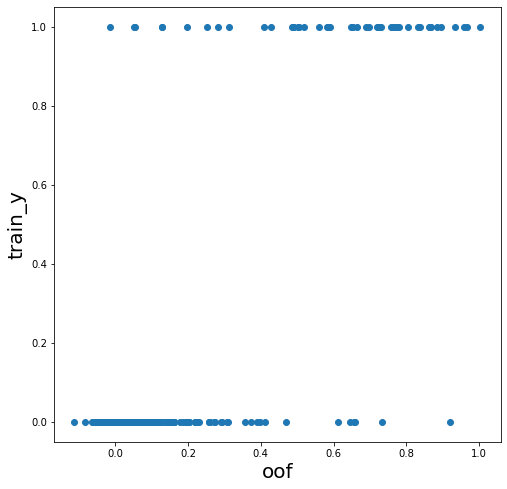

In [27]:
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('oof',fontsize=20)
ax.set_ylabel('train_y',fontsize=20)
ax.scatter(oof,y)

# Visualize Importance

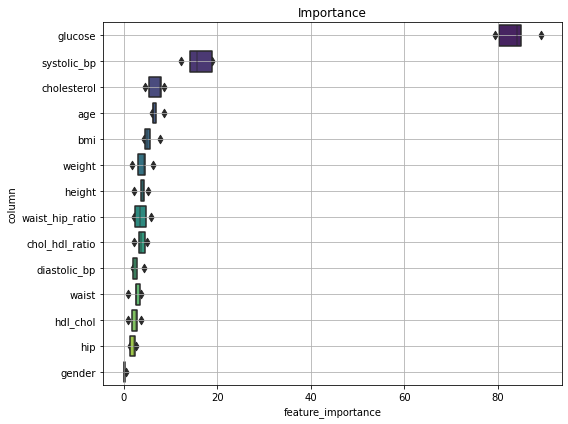

In [28]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=0)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig,ax

fig, ax = visualize_importance(models, train_feat_df)

### 'Glucose' is the most imprtant factor for 'Diabetes'.

# Predict

In [29]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
pred1 = np.mean(pred0, axis=0)
pred2 = np.where(pred1<0.5,0,1)
print(pred2[0:30])
print(testy[0:30])

[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
from sklearn.metrics import classification_report, log_loss, accuracy_score
accuracy=accuracy_score(testy,pred2)
print(accuracy)

0.9102564102564102


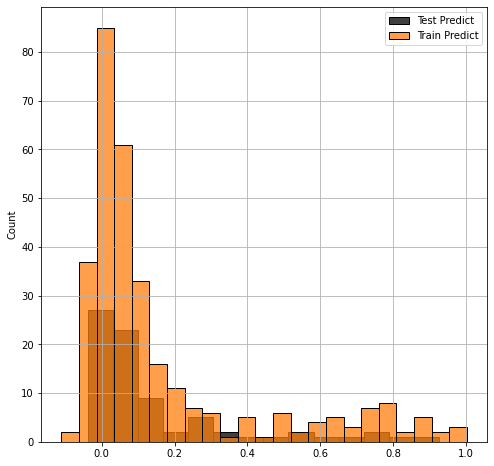

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(pred1, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Train Predict', ax=ax, color='C1')
ax.legend()
ax.grid()